### Target:

* Setting the basic foundations,Skeleton structure
* Make the model lighter 

### Results:

* Parameters: 15.3k
* Best Train Accuracy: 99.28
* Best Test Accuracy: 98.8

### Analysis:

* The model has more than 10k parameters
* model is slightly overfitted

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


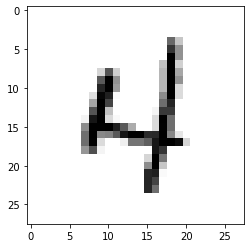

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

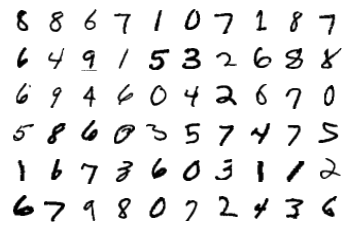

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convblock_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26*26*5

        self.convblock_2 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24*24*10

        self.maxPool = nn.MaxPool2d(2,2)#output=12*12*10

        self.convblock_3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        )#output= 10*10*15

        self.convblock_4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        )#output = 8*8*20

        self.convblock_5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        )#output = 6*6*20

        self.convblock_6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=6, padding=0, bias=False)
        )#1*1*10


    def forward(self, x):
        
        x = self.convblock_1(x)
        x = self.convblock_2(x)
        x = self.maxPool(x)
        x = self.convblock_3(x)
        x = self.convblock_4(x)
        x = self.convblock_5(x)
        x = self.convblock_6(x)
      
        x = x.reshape(-1,10)

        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [42]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              45
              ReLU-2            [-1, 5, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             450
              ReLU-4           [-1, 10, 24, 24]               0
         MaxPool2d-5           [-1, 10, 12, 12]               0
            Conv2d-6           [-1, 15, 10, 10]           1,350
              ReLU-7           [-1, 15, 10, 10]               0
            Conv2d-8             [-1, 20, 8, 8]           2,700
              ReLU-9             [-1, 20, 8, 8]               0
           Conv2d-10             [-1, 20, 6, 6]           3,600
             ReLU-11             [-1, 20, 6, 6]               0
           Conv2d-12             [-1, 10, 1, 1]           7,200
Total params: 15,345
Trainable params: 15,345
Non-trainable params: 0
----------------------------

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [43]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [44]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.18476486206054688 Batch_id=468 Accuracy=65.77: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]



Test set: Average loss: 0.1316, Accuracy: 9554/10000 (95.54%)

EPOCH: 1


Loss=0.07557953149080276 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]



Test set: Average loss: 0.0649, Accuracy: 9799/10000 (97.99%)

EPOCH: 2


Loss=0.09106554836034775 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]



Test set: Average loss: 0.0663, Accuracy: 9781/10000 (97.81%)

EPOCH: 3


Loss=0.035697173327207565 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]



Test set: Average loss: 0.0480, Accuracy: 9849/10000 (98.49%)

EPOCH: 4


Loss=0.03113136999309063 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]



Test set: Average loss: 0.0543, Accuracy: 9822/10000 (98.22%)

EPOCH: 5


Loss=0.012314118444919586 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]



Test set: Average loss: 0.0424, Accuracy: 9868/10000 (98.68%)

EPOCH: 6


Loss=0.024050896987318993 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]



Test set: Average loss: 0.0462, Accuracy: 9842/10000 (98.42%)

EPOCH: 7


Loss=0.03539498150348663 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]



Test set: Average loss: 0.0362, Accuracy: 9882/10000 (98.82%)

EPOCH: 8


Loss=0.017816362902522087 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]



Test set: Average loss: 0.0434, Accuracy: 9866/10000 (98.66%)

EPOCH: 9


Loss=0.02159344218671322 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]



Test set: Average loss: 0.0340, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.025133052840828896 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]



Test set: Average loss: 0.0362, Accuracy: 9883/10000 (98.83%)

EPOCH: 11


Loss=0.02653421275317669 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]



Test set: Average loss: 0.0383, Accuracy: 9871/10000 (98.71%)

EPOCH: 12


Loss=0.011656240560114384 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]



Test set: Average loss: 0.0339, Accuracy: 9891/10000 (98.91%)

EPOCH: 13


Loss=0.0010380366584286094 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]



Test set: Average loss: 0.0310, Accuracy: 9896/10000 (98.96%)

EPOCH: 14


Loss=0.003159887855872512 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]



Test set: Average loss: 0.0405, Accuracy: 9883/10000 (98.83%)



Text(0.5, 1.0, 'Test Accuracy')

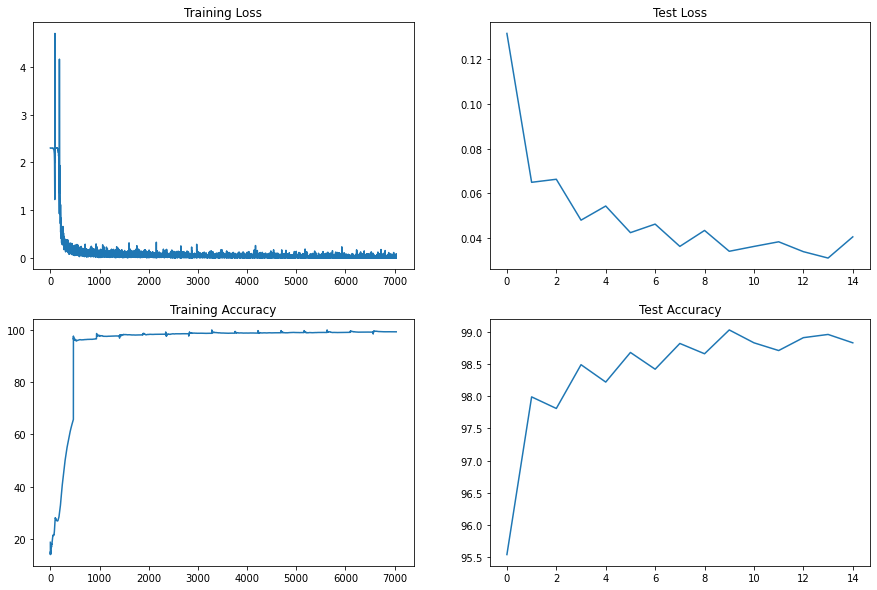

In [45]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")